<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Predicting-Prospect-Propensity" data-toc-modified-id="Predicting-Prospect-Propensity-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Predicting Prospect Propensity</a></span><ul class="toc-item"><li><span><a href="#Loading-and-Viewing-Data" data-toc-modified-id="Loading-and-Viewing-Data-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Loading and Viewing Data</a></span><ul class="toc-item"><li><span><a href="#Perform-Correlation-Analysis" data-toc-modified-id="Perform-Correlation-Analysis-1.1.1"><span class="toc-item-num">1.1.1&nbsp;&nbsp;</span>Perform Correlation Analysis</a></span></li></ul></li><li><span><a href="#Training-and-Testing-Split" data-toc-modified-id="Training-and-Testing-Split-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Training and Testing Split</a></span></li><li><span><a href="#Build-Model-and-Check-Accuracy" data-toc-modified-id="Build-Model-and-Check-Accuracy-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Build Model and Check Accuracy</a></span></li><li><span><a href="#Real-time-predictions" data-toc-modified-id="Real-time-predictions-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Real-time predictions</a></span></li></ul></li></ul></div>

 # Predicting Prospect Propensity

In this example, we will show you how to predict propensity of prospects. This code example goes with the lesson with the same title. We will use web clicks data about the links clicked by the user while the user is browsing to predict their propensity to buy the product. Using that propensity, we will decide whether we want to offer chat to the customer with an agent.

## Loading and Viewing Data
We will load the data file for this example and checkout summary statistics and columns for that file.

In [2]:
# Import libraries & packages
import pandas as pd
import numpy as np
import os
import matplotlib.pylab as plt
from sklearn.model_selection  import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
import sklearn.metrics

# Import data
prospect_data = pd.read_csv("browsing.csv")

# Preview data info
prospect_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 12 columns):
SESSION_ID         500 non-null int64
IMAGES             500 non-null int64
REVIEWS            500 non-null int64
FAQ                500 non-null int64
SPECS              500 non-null int64
SHIPPING           500 non-null int64
BOUGHT_TOGETHER    500 non-null int64
COMPARE_SIMILAR    500 non-null int64
VIEW_SIMILAR       500 non-null int64
WARRANTY           500 non-null int64
SPONSORED_LINKS    500 non-null int64
BUY                500 non-null int64
dtypes: int64(12)
memory usage: 47.0 KB


We can see this is a pretty small data set at 500 entries. However, for our purposes of learning and prototyping, this should suffice. In the real world we may have millions of entries/data points. 

The data contains information about the various links on the website that are clicked by the user during browsing. This is the data that will be used to build the model:

- **Session ID :** A unique identifier for the web browsing session
- **Buy :** Whether the prospect ended up buying the product
- **Other columns :** a 0 or 1 indicator to show whether the prospect visited that particular page or did the activity mentioned.


In [4]:
# Preview data
prospect_data.head()

,SESSION_ID,IMAGES,REVIEWS,FAQ,SPECS,SHIPPING,BOUGHT_TOGETHER,COMPARE_SIMILAR,VIEW_SIMILAR,WARRANTY,SPONSORED_LINKS,BUY
0,1001,0,0,1,0,1,0,0,0,1,0,0
1,1002,0,1,1,0,0,0,0,0,0,1,0
2,1003,1,0,1,1,1,0,0,0,1,0,0
3,1004,1,0,0,0,1,1,1,0,0,0,0
4,1005,1,1,1,0,1,0,1,0,0,0,0


We can see **BUY** is out target variable, and the rest are our predictor variables. 

In [3]:
# Summary statistics
prospect_data.describe().round()

,SESSION_ID,IMAGES,REVIEWS,FAQ,SPECS,SHIPPING,BOUGHT_TOGETHER,COMPARE_SIMILAR,VIEW_SIMILAR,WARRANTY,SPONSORED_LINKS,BUY
count,500.0,500.0,500.0,500.0,500.0,500.0,500.0,500.0,500.0,500.0,500.0,500.0
mean,1250.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0
std,144.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
min,1001.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,1126.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,1250.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0
75%,1375.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
max,1500.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


### Perform Correlation Analysis

Let's take an initial look to see if there are any standout actions that correlate with buying. 

In [18]:
prospect_data.corr().round(4)['BUY']

SESSION_ID         0.0267
IMAGES             0.0468
REVIEWS            0.4046
FAQ               -0.0951
SPECS              0.0099
SHIPPING          -0.0222
BOUGHT_TOGETHER   -0.1036
COMPARE_SIMILAR    0.1905
VIEW_SIMILAR      -0.0961
WARRANTY           0.1792
SPONSORED_LINKS    0.1103
BUY                1.0000
Name: BUY, dtype: float64

We can see the highest correlation is reviews, which makes sense. 

We can also see that some features e.g. REVIEWS, BOUGHT_TOGETHER, COMPARE_SIMILAR, WARRANTY and SPONSORED_LINKS have higher correlation to the target variable than the others. We will reduce our feature set to that list of variables.

In [20]:
# Keep columns with highest correlation (e.g. ~ > |0.1|)

# Keep/predictors
predictors = prospect_data[['REVIEWS',
                            'BOUGHT_TOGETHER',
                            'COMPARE_SIMILAR',
                            'WARRANTY',
                            'SPONSORED_LINKS']]

# Target
target = prospect_data.BUY

##  Training and Testing Split

We now split the model into training and testing data in the ratio of 70:30

In [22]:
# Split into train & test sets 
pred_train, pred_test, tar_train, tar_test  =  train_test_split(predictors, target, test_size=.3)

# Preview shape
print( "Predictor - Training : ", pred_train.shape, "Predictor - Testing : ", pred_test.shape )

Predictor - Training :  (350, 5) Predictor - Testing :  (150, 5)


Looks good. Proceed to build model. 

## Build Model and Check Accuracy

In [23]:
# Import Naive Bayes Classifier
from sklearn.naive_bayes import GaussianNB

# Instantiate Classifier
classifier = GaussianNB()

# Fit Classifier on Train Set
classifier = classifier.fit(pred_train, tar_train)

#  Make Predictions on Test Set
predictions = classifier.predict(pred_test)

# Check Accuracy of Predictions w/Confusion Matrix
sklearn.metrics.confusion_matrix(tar_test, predictions)

array([[81, 19],
       [24, 26]])

Let's go ahead and plot this normalized for a better visual.

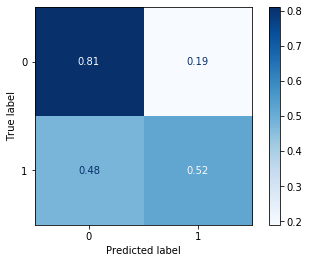

In [38]:
from sklearn.metrics import plot_confusion_matrix
sklearn.metrics.plot_confusion_matrix(classifier,
                                      pred_test,
                                      tar_test,
                                      normalize='true',
                                      cmap='Blues')
plt.show()

In [44]:
# Check Accuracy Score 
sklearn.metrics.accuracy_score(tar_test, predictions).round(5)

0.71333

Instead of doing a Yes/No prediction, we can instead do a probability computation to show the probability for the prospect to buy the product

In [45]:
# Calculate Probabilities
pred_prob = classifier.predict_proba(pred_test)

# Preview Probabilities [Yes, No]
pred_prob

array([[0.31376614, 0.68623386],
       [0.81885553, 0.18114447],
       [0.56408705, 0.43591295],
       [0.66457185, 0.33542815],
       [0.44845782, 0.55154218],
       [0.44845782, 0.55154218],
       [0.90910732, 0.09089268],
       [0.83181067, 0.16818933],
       [0.87375571, 0.12624429],
       [0.64975759, 0.35024241],
       [0.66457185, 0.33542815],
       [0.83181067, 0.16818933],
       [0.89790691, 0.10209309],
       [0.92337793, 0.07662207],
       [0.81885553, 0.18114447],
       [0.89790691, 0.10209309],
       [0.76360479, 0.23639521],
       [0.56408705, 0.43591295],
       [0.20798044, 0.79201956],
       [0.92337793, 0.07662207],
       [0.52699083, 0.47300917],
       [0.56408705, 0.43591295],
       [0.56408705, 0.43591295],
       [0.89790691, 0.10209309],
       [0.88727306, 0.11272694],
       [0.81885553, 0.18114447],
       [0.64975759, 0.35024241],
       [0.44845782, 0.55154218],
       [0.56408705, 0.43591295],
       [0.76360479, 0.23639521],
       [0.

The probability above can be read as first column = chance that the prospect will buy the product & second column = chance the prospect won't buy the product. 

## Real-time predictions

Now that the model has been built, let's use it for real-time predictions. This way, when the customer visits the pages, we collect that information and use it to compute probability. We will compute probability for every new click that comes in with our real-time predictor variable data.

Let's now imagine the prospect has landed on the website. There are no significant clicks yet. Let's compute probability of buying. 

The array of values passed has the values for our predictor variables: REVIEWS, BOUGHT_TOGETHER, COMPARE_SIMILAR, WARRANTY and SPONSORED_LINKS. Since the visitor has just landed on the first page, the array will start out as all zeros.

In [46]:
# Set imaginary browsing data based on first landing
browsing_data = np.array([0,0,0,0,0]).reshape(1, -1)

# Predict probability of buying
print("New visitor: propensity :",classifier.predict_proba(browsing_data)[:,1] )

New visitor: propensity : [0.04458193]


So the initial probability is 4%. Now, suppose the customer does a comparison of similar products. The array changes to include a 1 for that function. The new probability will be

In [47]:
# Set imaginary browsing data based on comparison of similar products
browsing_data = np.array([0,0,1,0,0]).reshape(1, -1)

# Predict new probability of buying
print("After checking similar products: propensity :",classifier.predict_proba(browsing_data)[:,1] )

After checking similar products: propensity : [0.12624429]


It goes up. Next, the visitor checks out the product reviews.

In [48]:
# Set imaginary browsing data based on reading product reviews
browsing_data = np.array([1,0,1,0,0]).reshape(1, -1)

# Predict new probability of buying
print("After checking reviews: propensity :",classifier.predict_proba(browsing_data)[:,1] )

After checking reviews: propensity : [0.6098075]


It shoots up to 60+%. You can have a threshold for when you want to offer chat. You can keep checking this probability against that threshold to see if you want a chat window to popup.

This example shows how to use predictive analytics in real time to decide whether a prospect has high propensity to convert and offer them a chat with a live sales rep/agent.